In [2]:
# Project imports
from sutton import (
    Params,
    thomas,
    our_central_difference,
    integrate_T_implicit,
    integrate_H2O_implicit,
    stability,
    saturation_vapor_pressure,
    vapor_concentration_RH,
)

In [1]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import sys
import math

CPU times: user 1.9 s, sys: 759 ms, total: 2.66 s
Wall time: 419 ms


In [3]:
# Using functions from sutton.physics and sutton.integrators; no local duplicates needed.
# integrate_H2O_implicit, vapor_concentration_RH, vapor_concentration are imported from sutton.

In [8]:
from sutton import Params, saturation_vapor_pressure, vapor_concentration_RH
import numpy as np
import math

def get_params(fallow_fraction = 0.5, fallow_length = 500, 
               T_c = 30, T_f = 50,
               RH_c = 43, RH_f = 12,):
    # Build using Params then augment with notebook-specific values
    zom = 0.22
    p = Params(Lx=3500, Hmax=100, dz=0.5, dx=5, zom_f=zom, zom_c=zom)
    p.fallow_fraction = fallow_fraction
    p.fallow_length = fallow_length
    p.T_sc = T_c
    p.T_sf = T_f
    p.RH_c = RH_c
    p.RH_f = RH_f
    d = p.to_dict()
    
    # Surface conditions (override to match this notebook)
    es_c = saturation_vapor_pressure(T_c + 273.15)
    Q_c = vapor_concentration_RH(T_c, RH_c)
    es_f = saturation_vapor_pressure(T_f + 273.15)
    Q_f  = 8  # legacy constant used in this notebook
    Q_a  = vapor_concentration_RH(T_f, 10)
    
    print(f"Cultivated \nSaturation vapor pressure at T={T_c}°C, RH={RH_c}% is {es_c:.2f} Pa")
    print(f"Water vapor concentration is {Q_c:.2f} g/m³")
    print(f"Fallow \nSaturation vapor pressure at T={T_f}°C, RH={RH_f}% is {es_f:.2f} Pa")
    print(f"Water vapor concentration is {Q_f:.2f} g/m³")
    
    # Patch geometry (explicit for clarity)
    patch_size = int(fallow_length / d['dx'])
    gap_size = int(patch_size * (1 - fallow_fraction) / fallow_fraction) if fallow_fraction > 0 else 0
    
    # Compute legacy single ustar using 10 m reference like original notebook
    Ubar_10 = 4.0
    ustar = d['k'] * Ubar_10 / np.log(10.0 / zom)
    
    # Assemble expected keys
    d.update({
        'fallow_fraction': fallow_fraction,
        'fallow_length': fallow_length,
        'patch_size': patch_size,
        'gap_size': gap_size,
        'T_c': T_c, 'T_f': T_f,
        'Q_c': Q_c, 'Q_f': Q_f, 'Q_a': Q_a,
        'zom': zom,
        'ustar': ustar,
        'xmin': 0,
        'xmax': d['Lx'],
        'zmin': zom,
        'zmax': d['Hmax'],
        'nx': int(d['Lx']/d['dx']) + 1,
        'nz': int((d['Hmax']-zom)/d['dz']) + 1,
    })
    return d

In [5]:
def populate_Qc_array(params):
    """
    Retrieve parameters from the dictionary
    """
    x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])
    nx = len(x)
    patch_size = params["patch_size"]
    gap_size = params["gap_size"]
    Q_c = params["Q_c"]
    Q_f = params["Q_f"]
    
    # Initialize the array with zeros or any other default value
    Q_c_array = [0] * (nx)
    
    # Populate the array with alternating patches
    i = 0
    
    while i < nx :
        # Assign a vegetated patch of fixed length
        Q_c_array[i:i + patch_size] = [Q_c] * min(patch_size, nx  - i)
        i += patch_size
        
        # Assign a fallow patch of fixed length, if within bounds
        if i < nx :
            Q_c_array[i:i + gap_size] = [Q_f] * min(gap_size, nx  - i)
            i += gap_size
            
    return np.array(Q_c_array)

In [9]:
params = get_params()

# Call the function with the parameter dictionary
Qs_array = populate_Qc_array(params)

ustar = params['ustar']
k = params['k']
Hmax = params['Hmax']
zom = params['zom']
Q_a = params['Q_a']
Q_c = params['Q_c']
Q_f = params['Q_f']
z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], params['dz'])
dz = params['dz']
dx = params['dx']

nx = params['nx']
nz = params['nz']

# check these equations
LE_c = ustar*k*(Q_c - Q_a)/np.log(Hmax/zom)  # m/s g/m3 = g /m2 s
LE_f = ustar*k*(Q_f - Q_a)/np.log(Hmax/zom)

# Specify upwind wv concentration (as background)
Qup_f = Q_f - LE_f/(k*ustar)*np.log(z/zom)
# Qup = np.ones_like(z) * Q_a

# Generate the mean velocity profile from the log-law
U = (ustar / k) * np.log(z / zom)
Q_f

Cultivated 
Saturation vapor pressure at T=30°C, RH=43% is 4353.80 Pa
Water vapor concentration is 13.04 g/m³
Fallow 
Saturation vapor pressure at T=50°C, RH=12% is 13163.46 Pa
Water vapor concentration is 8.00 g/m³


8

In [10]:
def varying_Qs(nx, nz, dx, dz, k, z, ustar, U, Qup_f, Qs_array, Q_a, h):
    
    # Setup coefficients for the implicit scheme
    zom = h/10
    d = 2/3*h
    # Setup coefficients for the implicit scheme
    lm = k * (z - d)    # mixing length
    lm[z < h] = k*h/3
    
    A = lm * ustar
    B = 1.0 / U
    C = our_central_difference(A, dz)

    # Initialize upwind water vapor concentrations and fluxes
    Q1 = Qup_f
    Q = np.zeros((nx, nz))
    Q[0, :] = Q1
    FluxQ = np.zeros((nx, nz))

    # Perform downwind calculations by marching along x
    for i, Qs_i in enumerate(Qs_array):

        Q2, Fq = integrate_H2O_implicit(nx, nz, dx, dz, A, B, C, Q1, Qs_i, Q_a)
        Q[i , :] = Q2
        FluxQ[i , :] = Fq

        Q1 = Q2

    return Q, FluxQ

def uniform_Q(nx, nz, dx, dz, k, z, ustar, U, Qup_f, Q_s, Q_a, h):

    zom = h/10
    d = 2/3*h
    # Setup coefficients for the implicit scheme
    lm = k * (z - d)    # mixing length
    lm[z < h] = k*h/3
    
    A = lm * ustar
    B = 1.0 / U
    C = our_central_difference(A, dz)

    # Upwind wv concentrations and fluxes
    Q1 = Qup_f
    Q_uniform = np.zeros((nx , nz))
    Q_uniform[0, :] = Q1
    FluxQ_uniform = np.zeros((nx , nz))

    # Begin downwind calculations by marching along x
    for i in range(nx):
        Q2, Fq = integrate_H2O_implicit(nx, nz, dx, dz, A, B, C, Q1, Q_s, Q_a)
        Q_uniform[i, :] = Q2
        FluxQ_uniform[i, :] = Fq
        Q1 = Q2

    return Q_uniform, FluxQ_uniform

# def uniform_fallow(nx, nz, dx, dz, k, z, ustar, U, Qup_f, Q_f, Q_a, h):
    
#     zom = h/10 # momentum 
#     d = 2/3*h # zero plane displacement
    
#     # Setup coefficients for the implicit scheme
#     lm = k * (z - d)    # mixing length
#     lm[z < h] = k*h/3
    
#     A = lm * ustar
#     B = 1.0 / U
#     C = our_central_difference(A, dz)    
    
#     # Upwind wv concentrations and fluxes
#     Q1 = Qup_f
#     Q_fallow = np.zeros((nx , nz))
#     Q_fallow[0, :] = Q1
#     FluxQ_fallow = np.zeros((nx , nz))

#     # Begin downwind calculations by marching along x
#     for i in range(nx):
#         Q2, Fq = integrate_H2O_implicit(nx, nz, dx, dz, A, B, C, Q1, Q_f, Q_a)
#         Q_fallow[i, :] = Q2
#         FluxQ_fallow[i, :] = Fq
#         Q1 = Q2

#     return Q_fallow, FluxQ_fallow

def ET_enhance(FluxQ_uniform, FluxQ_fallow, FluxQ):
    
    continuous_cultivation = FluxQ_uniform[nx-1, 0]*dx
    
    uniform_flux = FluxQ_uniform[nx-1, 0]*(Qs_array > Q_f).mean() + \
                FluxQ_fallow[nx-1, 0]*(Qs_array == Q_f).mean()
    uniform_flux = uniform_flux*dx
    
    FluxQ_force = FluxQ.copy()
    FluxQ_force[Qs_array < Q_c] = FluxQ_fallow[-1,0]
    
    return  continuous_cultivation, uniform_flux, FluxQ_force[:, 0].mean()*dx
    
    


In [11]:
h = 2.3
Q, FluxQ = varying_Qs(nx, nz, dx, dz, k, z, ustar, U, Qup_f, Qs_array, Q_a, zom)
Q_uniform, FluxQ_uniform = uniform_Q(nx, nz, dx, dz, k, z, ustar, U, Qup_f, Q_c, Q_a, h)
Q_fallow, FluxQ_fallow = uniform_Q(nx, nz, dx, dz, k, z, ustar, U, Qup_f, Q_f, Q_a, zom)        
    
continuous_cultivation, uniform_flux, patchy_flux = ET_enhance(FluxQ_uniform, FluxQ_fallow, FluxQ)    
FluxQ_neg = FluxQ.copy()
FluxQ[Qs_array < Q_c] = FluxQ_fallow[-1,3]

z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], params['dz'])
x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])

QQ = np.sum(Q - Q_a, axis=1) * dz
QQ_uniform = np.sum(Q_uniform - Q_a, axis=1) * dz

print(patchy_flux/continuous_cultivation, patchy_flux/uniform_flux)

0.9845190178109997 1.810835058539823


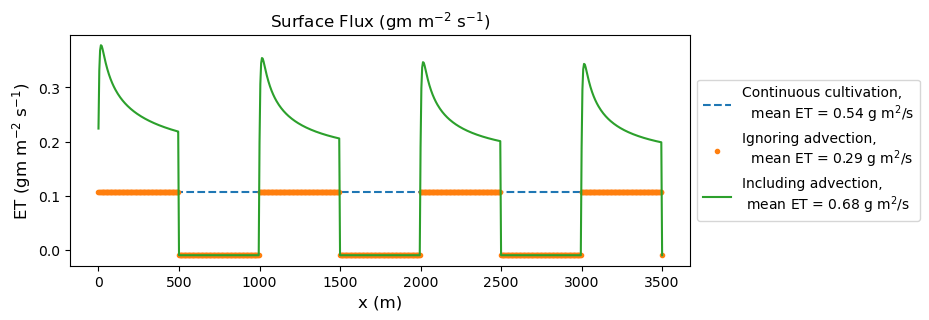

In [11]:
plt.figure(figsize = (8, 3))
ax = plt.gca()

plt.plot(x, np.ones(nx ) * FluxQ_uniform[nx-1, 3], '--',  
         label = "Continuous cultivation, \n  mean ET = {0:.2f} g m$^2$/s".format(
             FluxQ_uniform[nx-1, 3]*dx))

uniform_flux = FluxQ_uniform[nx-1, 3]*(Qs_array > Q_f).mean() + \
                FluxQ_fallow[nx-1, 3]*(Qs_array == Q_f).mean()
plt.plot(x, FluxQ_uniform[nx-1, 3]*(Qs_array > Q_f) + FluxQ_fallow[nx-1, 3]*(Qs_array == Q_f), '.', 
         label = "Ignoring advection, \n  mean ET = {0:.2f} g m$^2$/s".format(
    uniform_flux*dx))

# FluxQ[Qs_array < Q_c] = FluxQ_fallow[-1,3]
plt.plot(x[:], FluxQ[:, 3], '-', label = "Including advection,  \n mean ET = {0:.2f} g m$^2$/s".format(
    FluxQ[:, 3].mean()*dx))

plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('ET (gm m$^{-2}$ s$^{-1}$)', fontsize=12, fontweight='normal')
plt.title('Surface Flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# (FluxQ[:, 3].sum()*dx/nx - FluxQ[nx:,  3].sum()*dx)/(FluxQ[nx:,  3].sum()*dx)


In [12]:
z[2] + 2.3/3*2

3.253333333333333

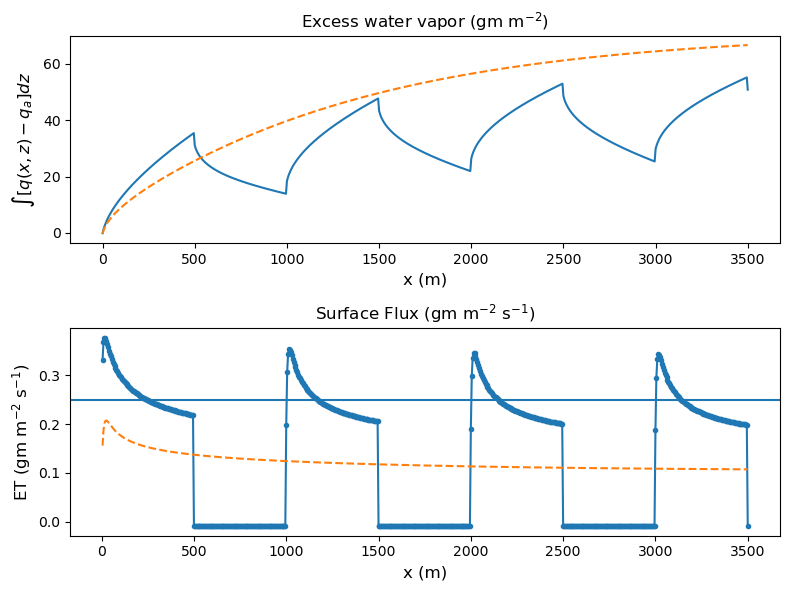

In [13]:
# Plot excess water vapor and surface flux
plt.figure(figsize = (8, 6))


plt.subplot(2, 1, 1)
plt.plot(x, QQ, '-', label = 'Fallow patches')
plt.plot(x, QQ_uniform, '--', label = 'Uniform cultivated')

plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel(r'$\int [q(x,z) - q_a]dz$', fontsize=12, fontweight='normal')
plt.title('Excess water vapor (gm m$^{-2}$)', fontsize=12)


plt.subplot(2, 1, 2)
plt.plot(x[1:], FluxQ[1:, 3], '.-')
plt.plot(x[1:],  FluxQ_uniform[1:, 3], '--')
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('ET (gm m$^{-2}$ s$^{-1}$)', fontsize=12, fontweight='normal')
plt.title('Surface Flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)
plt.tight_layout()
plt.axhline(0.25)
# plt.ylim(0, )

In [14]:
h*2/3 + 1.4

2.933333333333333

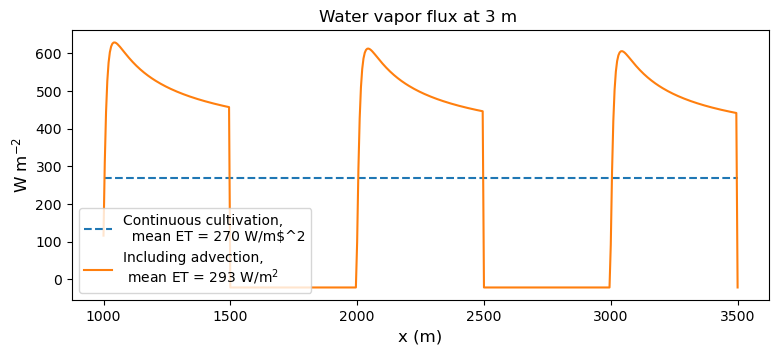

In [15]:
plt.figure(figsize = (9, 3.5))
ax = plt.gca()

plt.plot(x[200:], np.ones(nx )[200:] * FluxQ_uniform[nx-1, 5]*2260, '--',  
         label = "Continuous cultivation, \n  mean ET = {0:.0f} W/m$^2".format(
             FluxQ_uniform[nx-1, 5]*2260))

uniform_flux = FluxQ_uniform[nx-1, 5]*(Qs_array > Q_f).mean() + \
                FluxQ_fallow[nx-1, 5]*(Qs_array == Q_f).mean()
# plt.plot(x, FluxQ_uniform[nx-1, 5]*(Qs_array > Q_f)*2260 + 
#          FluxQ_fallow[nx-1, 5]*(Qs_array == Q_f)*2260, '.',  
#          label = "Ignoring advection, \n  mean ET = {0:.2f} g m$^2$/s".format(uniform_flux*2260))

# FluxQ[Qs_array < Q_c] = FluxQ_fallow[-1,5]
plt.plot(x[200:], FluxQ[200:, 5]*2260, '-', label = "Including advection,  \n mean ET = {0:.0f} W/m$^2$".format(
    FluxQ[200:, 5].mean()*2260))

plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('W m$^{-2}$', fontsize=12, fontweight='normal')
plt.title('Water vapor flux at 3 m ', fontsize=12)
ax.legend()#loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_ylim(50, 600)
# (FluxQ[200:, 5].sum()*dx/nx - FluxQ[nx:,  5].sum()*dx)/(FluxQ[nx:,  5].sum()*dx)


In [16]:
z[5]

3.2199999999999998

In [17]:
(Qs_array > Q_f).mean()

0.5706134094151213

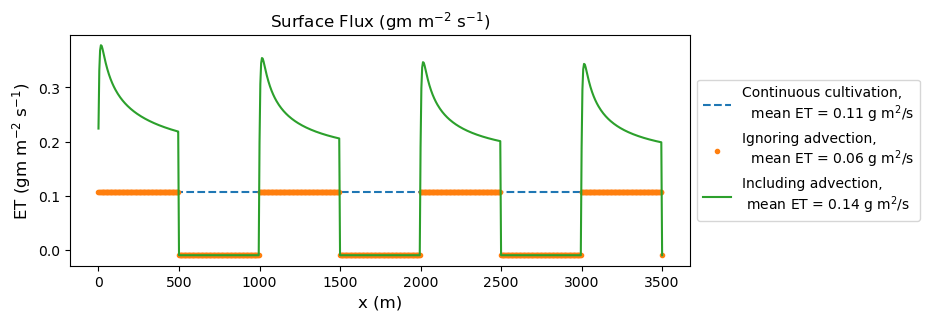

In [18]:

plt.figure(figsize = (8, 3))
ax = plt.gca()

plt.plot(x, np.ones(nx ) * FluxQ_uniform[nx-1, 3], '--',  
         label = "Continuous cultivation, \n  mean ET = {0:.2f} g m$^2$/s".format(
             FluxQ_uniform[nx-1, 3]))

uniform_flux = FluxQ_uniform[nx-1, 3]*(Qs_array > Q_f).mean() + \
                FluxQ_fallow[nx-1, 3]*(Qs_array == Q_f).mean()
plt.plot(x, FluxQ_uniform[nx-1, 3]*(Qs_array > Q_f) + FluxQ_fallow[nx-1, 3]*(Qs_array == Q_f), '.',  label = "Ignoring advection, \n  mean ET = {0:.2f} g m$^2$/s".format(
    uniform_flux))

# FluxQ[Qs_array < Q_c] = FluxQ_fallow[-1,3]
plt.plot(x[:], FluxQ[:, 3], '-', label = "Including advection,  \n mean ET = {0:.2f} g m$^2$/s".format(
    FluxQ[:, 3].mean()))

plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('ET (gm m$^{-2}$ s$^{-1}$)', fontsize=12, fontweight='normal')
plt.title('Surface Flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# (FluxQ[:, 3].sum()*dx/nx - FluxQ[nx:,  3].sum()*dx)/(FluxQ[nx:,  3].sum()*dx)

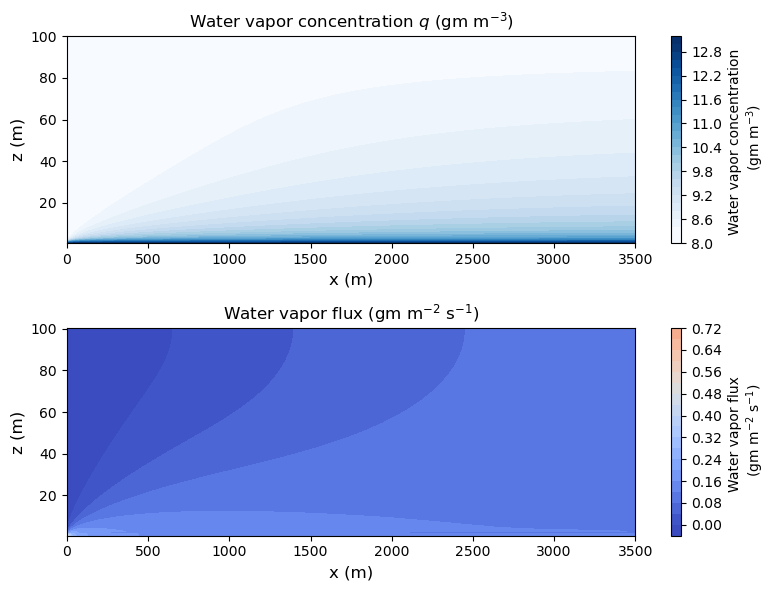

In [19]:
z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], params['dz'])
x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])

# Plot water vapor concentration and vertical flux
plt.figure(figsize = (8, 6))

plt.subplot(2, 1, 1)
plt.contourf(x, z, (Q_uniform.T), 25, cmap='Blues',  vmax = Q_c, vmin = Q_a)
plt.colorbar(label='Water vapor concentration \n (gm m$^{-3}$)')
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor concentration $q$ (gm m$^{-3}$)', fontsize=12)

plt.subplot(2, 1, 2)
plt.contourf(x, z, FluxQ_uniform.T.round(4),  20, cmap='coolwarm', vmin = 0, vmax = 1)
plt.colorbar(label='Water vapor flux \n (gm m$^{-2}$ s$^{-1}$)') 
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)
plt.tight_layout()



In [26]:
Q_f, Q_a

(8, 8.28817322179911)

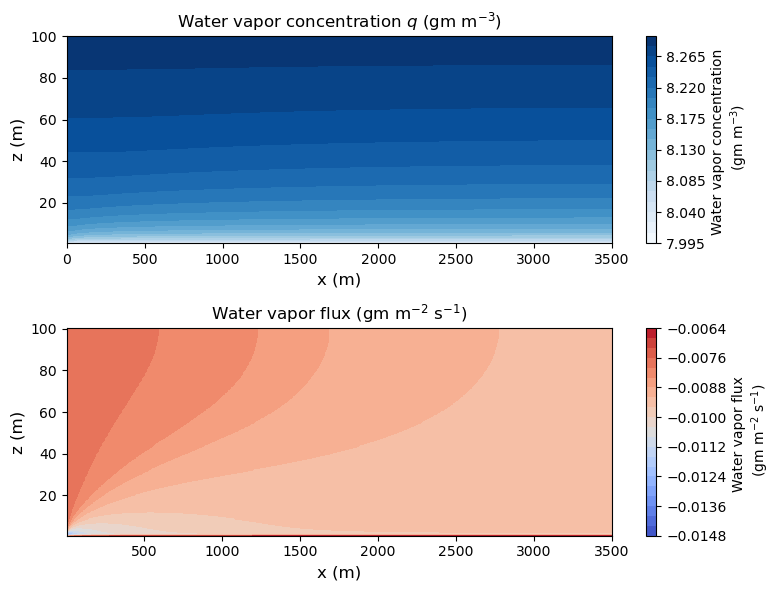

In [28]:


z = np.arange(params['zmin'] + params['dz'], params['zmax'] + params['dz'], params['dz'])
x = np.arange(params['xmin'], params['xmax'] + params['dx'], params['dx'])

# Plot water vapor concentration and vertical flux
plt.figure(figsize = (8, 6))

plt.subplot(2, 1, 1)
plt.contourf(x, z, (Q_fallow.T), 25, cmap='Blues',  )#vmax = Q_f, vmin = Q_a)
plt.colorbar(label='Water vapor concentration \n (gm m$^{-3}$)')
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor concentration $q$ (gm m$^{-3}$)', fontsize=12)

plt.subplot(2, 1, 2)
plt.contourf(x[1:], z, FluxQ_fallow[1:].T.round(4),  20, cmap='coolwarm')
plt.colorbar(label='Water vapor flux \n (gm m$^{-2}$ s$^{-1}$)') 
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)
plt.tight_layout()


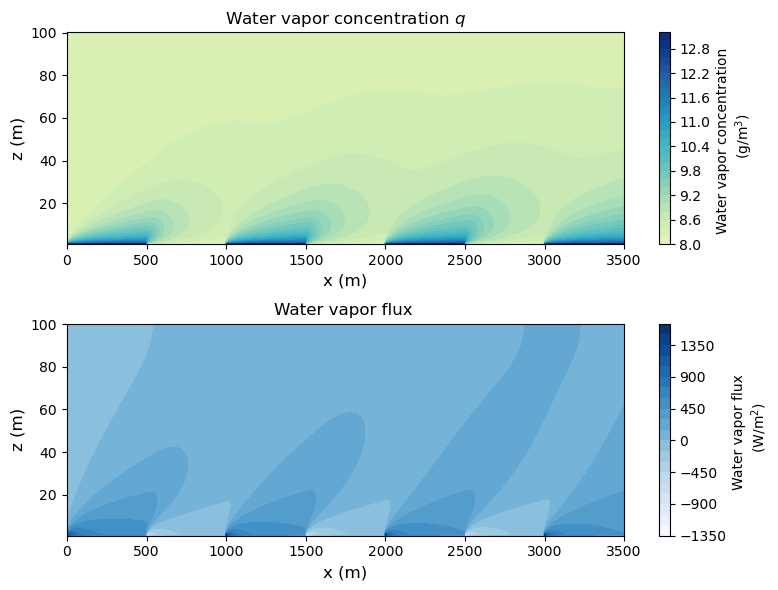

In [29]:
# Plot water vapor concentration and vertical flux
plt.figure(figsize = (8, 6))

# Normalized concentration (if needed)
# Qd = (Q - Qa) / (Qs - Qa)
blues = ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']
from matplotlib.colors import LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list('custom_blues', blues)

plt.subplot(2, 1, 1)
plt.contourf(x, z, (Q.T), 25, cmap=custom_cmap,  vmax = 13, vmin = 7)
plt.colorbar(label='Water vapor concentration \n (g/m$^3$)')
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor concentration $q$ ', fontsize=12)

plt.subplot(2, 1, 2)

plt.contourf(x, z, FluxQ_neg.T.round(4)*2260,  20, cmap='Blues') #vmin = -0.2, vmax = 0.5)
plt.colorbar(label='Water vapor flux \n (W/m$^2$)') 
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor flux ', fontsize=12)

plt.tight_layout()
plt.show()


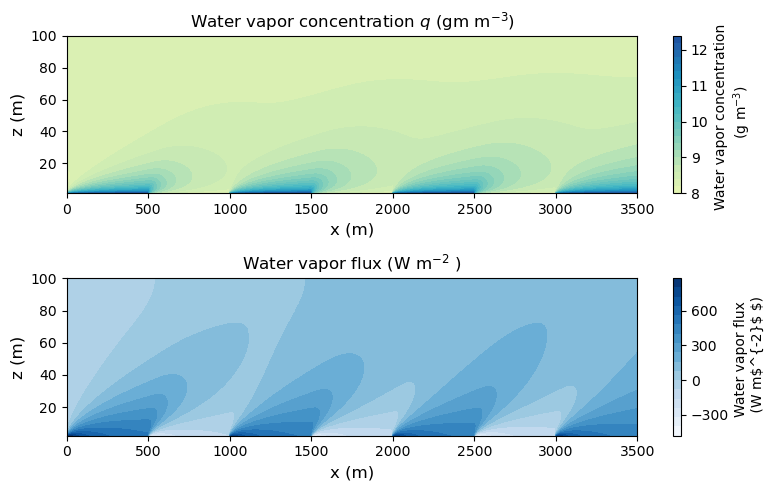

In [30]:
# Reduce the number of tick labels for colorbars
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap

# Create custom colormap
blues = ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']
custom_cmap = LinearSegmentedColormap.from_list('custom_blues', blues)

plt.figure(figsize=(8,5))

# Subplot 1: Water vapor concentration
plt.subplot(2, 1, 1)
contour1 = plt.contourf(x, z[1:], Q[:, 1:].T, 25, cmap=custom_cmap, vmax=13, vmin=7)
cbar1 = plt.colorbar(contour1, label='Water vapor concentration \n (g m$^{-3}$)')
cbar1.ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))  # Reduce tick labels
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor concentration $q$ (gm m$^{-3}$)', fontsize=12)

# Subplot 2: Water vapor flux
plt.subplot(2, 1, 2)
contour2 = plt.contourf(x, z[3:], FluxQ_neg[:, 3:].T.round(4)*2260, 20, cmap='Blues')
cbar2 = plt.colorbar(contour2, label='Water vapor flux \n (W m$^{-2}$ $)')
cbar2.ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))  # Reduce tick labels
plt.xlabel('x (m)', fontsize=12, fontweight='normal')
plt.ylabel('z (m)', fontsize=12, fontweight='normal')
plt.title('Water vapor flux (W m$^{-2}$ )', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'y=(Q-Q_a)/(Q_s-Q_a)')

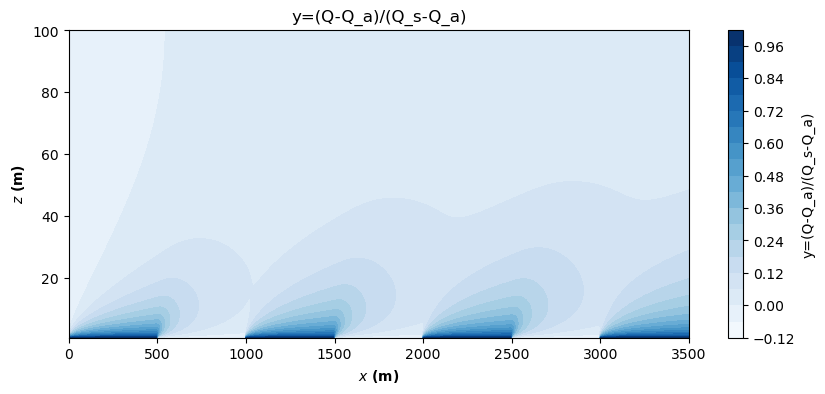

In [31]:

# Normalized concentration
Q_d = (Q - Q_a) / (Q_c - Q_a)

plt.figure(3, figsize = (10,4))
plt.clf()
plt.contourf(x, z, Q_d.T, 20, vmax =1, cmap='Blues')
plt.xlabel(r'$\it{x}$ (m)', fontweight='bold', fontsize=10)
plt.ylabel(r'$\it{z}$ (m)', fontweight='bold', fontsize=10)
plt.colorbar(label='y=(Q-Q_a)/(Q_s-Q_a)')
plt.title('y=(Q-Q_a)/(Q_s-Q_a)')


In [22]:

# # Create a 3D plot
X, Z = np.meshgrid(x, z)
# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111, projection='3d')

# # Plot the surface
# surf = ax.plot_surface(X, Z, FluxQ.T, cmap='GnBu', vmin=-0.2, vmax=0.51)

# # Add color bar
# cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
# cbar.set_label('Water vapor flux \n (gm m$^{-2}$ s$^{-1}$)', fontsize=10)

# # Set labels and title
# ax.set_xlabel('x (m)', fontsize=12)
# ax.set_ylabel('z (m)', fontsize=12)
# ax.set_zlabel('Water vapor flux \n (gm m$^{-2}$ s$^{-1}$)', fontsize=10)
# ax.set_title('Water Vapor Flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)

# plt.show()


Text(0.5, 0.92, 'Water Vapor Flux (gm m$^{-2}$ s$^{-1}$)')

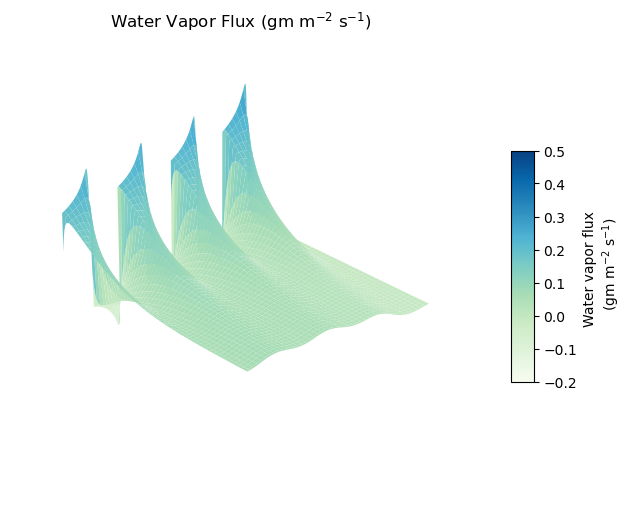

In [23]:
# Create a 3D plot with axes turned off
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X[5:, :],Z[5:, :], FluxQ_neg.T[5:, :], cmap='GnBu', vmin=-0.2, vmax=0.5)

# Add color bar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Water vapor flux \n (gm m$^{-2}$ s$^{-1}$)', fontsize=10)
ax.view_init(elev=30, azim=45)
# Turn off axes
ax.axis('off')

# Set title
ax.set_title('Water Vapor Flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)
